In [1]:
# Random Forests Model

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from mlxtend.evaluate import bias_variance_decomp
%matplotlib inline
sns.set()

In [4]:
# reading loans data

loans = pd.read_csv('lending_club_loan.csv')

In [5]:
# function to fill in missing values of mort_acc

def fill_mort_acc(total_acc,mort_acc):
    if np.isnan(mort_acc):
        return total_acc_avg[total_acc]
    else:
        return mort_acc

In [6]:
# feature engineering

loans['loan_repaid'] = loans['loan_status'].map({'Fully Paid':1,'Charged Off':0})
total_acc_avg = loans.groupby('total_acc').mean()['mort_acc']
loans['mort_acc'] = loans.apply(lambda x: fill_mort_acc(x['total_acc'], x['mort_acc']), axis=1)

#categorical variables
loans['term'] = loans['term'].apply(lambda term: int(term[:3]))
loans['home_ownership']=loans['home_ownership'].replace(['NONE', 'ANY'], 'OTHER')
loans['zip_code'] = loans['address'].apply(lambda address:address[-5:])
loans['earliest_cr_year'] = loans['earliest_cr_line'].apply(lambda date:int(date[:4]))

dummies = pd.get_dummies(loans[['zip_code','home_ownership','grade','verification_status', 'application_type','initial_list_status','purpose' ]],drop_first=True)
loans = loans.drop(['zip_code','address', 'home_ownership', 'grade','verification_status', 'application_type','initial_list_status','purpose'],axis=1)
loans = pd.concat([loans,dummies],axis=1)

loans = loans.drop(['emp_title','emp_length','title','sub_grade', 'issue_d', 'earliest_cr_line', 'loan_status'],axis=1)
loans = loans.dropna()

In [7]:
# separating attributes from labels

X = loans.drop('loan_repaid',axis=1).values
y = loans['loan_repaid'].values

In [8]:
# train-test-validation split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=101)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=101)

In [9]:
# Normalizing the data

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [10]:
# Baseline Random Forest Model

rfc = RandomForestClassifier(n_estimators=5, random_state=11, class_weight={0: 0.195, 1: 0.804})
rfc.fit(X_train, y_train)
pred = rfc.predict(X_val)

In [11]:
# accuracy on validation data

print(classification_report(y_val, pred))
print('\n Accuracy on validation data: ', accuracy_score(y_val, pred))

              precision    recall  f1-score   support

           0       0.73      0.54      0.62      1444
           1       0.90      0.95      0.92      6042

    accuracy                           0.87      7486
   macro avg       0.81      0.74      0.77      7486
weighted avg       0.86      0.87      0.86      7486


 Accuracy on validation data:  0.8722949505744055


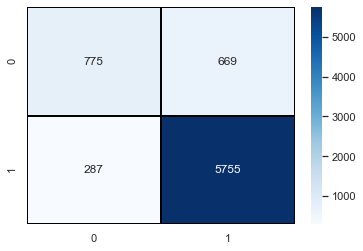

In [12]:
# confusion matrix

sns.heatmap(confusion_matrix(y_val, pred), annot = True, fmt = 'd', cmap = 'Blues', linewidths=1, linecolor='black')

In [13]:
# F1 score and  Area under precision-recall curve for validation data

rfc_probs = rfc.predict_proba(X_val)
rfc_probs = rfc_probs[:, 1]
rfc_precision, rfc_recall, _ = precision_recall_curve(y_val, rfc_probs)
rfc_f1, rfc_auc = f1_score(y_val, pred), auc(rfc_recall, rfc_precision)
print('Random Forests : F1 Score = %.3f , PR-AUC=%.3f' % (rfc_f1, rfc_auc))

Random Forests : F1 Score = 0.923 , PR-AUC=0.946


In [14]:
# Finding best parameters

model = RandomForestClassifier(random_state=11)
param_grid = [{'n_estimators': [10, 20, 30], 'max_features': [5, 10], 'max_depth': [10, 50, None]}]

grid_search_forest = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
grid_result = grid_search_forest.fit(X_val, y_val)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.892733 using {'max_depth': 10, 'max_features': 10, 'n_estimators': 20}


In [15]:
# Final Model with new parameters

rfc_final = RandomForestClassifier(n_estimators=20, max_depth=10, max_features=10, 
                                   random_state=11, class_weight={0: 0.195, 1: 0.804})
rfc_final.fit(X_train, y_train)

RandomForestClassifier(class_weight={0: 0.195, 1: 0.804}, max_depth=10,
                       max_features=10, n_estimators=20, random_state=11)

In [16]:
# Accuracy on validation data

pred = rfc_final.predict(X_val)
print(classification_report(y_val, pred))
print('\n Accuracy on validation data: ', accuracy_score(y_val, pred))

              precision    recall  f1-score   support

           0       1.00      0.44      0.62      1444
           1       0.88      1.00      0.94      6042

    accuracy                           0.89      7486
   macro avg       0.94      0.72      0.78      7486
weighted avg       0.91      0.89      0.88      7486


 Accuracy on validation data:  0.8928666844776917


In [17]:
# Accuracy on test data

r_pred = rfc_final.predict(X_test)
print(classification_report(y_test, r_pred))
print('\n Accuracy on test data: ', accuracy_score(y_test, r_pred))

              precision    recall  f1-score   support

           0       1.00      0.42      0.59      1395
           1       0.88      1.00      0.94      6092

    accuracy                           0.89      7487
   macro avg       0.94      0.71      0.76      7487
weighted avg       0.90      0.89      0.87      7487


 Accuracy on test data:  0.8915453452651262


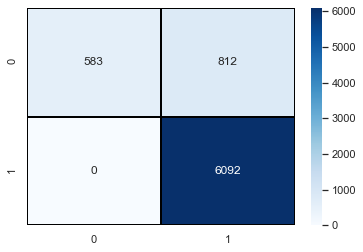

In [18]:
# confusion matrix of test data

sns.heatmap(confusion_matrix(y_test, r_pred), annot = True, fmt = 'd', cmap = 'Blues', linewidths=1, linecolor='black')

In [19]:
# F1 score and  Area under precision-recall curve for test data

rfc_probs = rfc_final.predict_proba(X_test)
rfc_probs = rfc_probs[:, 1]
rfc_precision, rfc_recall, _ = precision_recall_curve(y_test, rfc_probs)
rfc_f1, rfc_auc = f1_score(y_test, r_pred), auc(rfc_recall, rfc_precision)
print('RF Model: F1 score = %.3f PR-AUC = %.3f' % (rfc_f1, rfc_auc))

RF Model: F1 score = 0.938 PR-AUC = 0.970


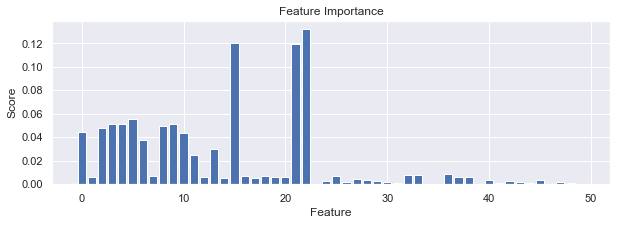

In [20]:
# feature importance

importance = rfc.feature_importances_

plt.figure(figsize = (10,3))
plt.bar([x for x in range(len(importance))], importance)
plt.xlabel('Feature')
plt.ylabel('Score')
plt.title('Feature Importance')
plt.show()

In [21]:
# Bias and variance of model

mse, bias, var = bias_variance_decomp(rfc, X_train, y_train, X_test, y_test, loss='mse', num_rounds=10, random_seed=11)
print('Average MSE: %.3f' % mse)
print('Average Bias: %.3f' % bias)
print('Average Variance: %.3f' % var)

Average MSE: 0.129
Average Bias: 0.090
Average Variance: 0.039
